# Glasses detection

This notebook aims to detect whether somebody is wearing glasses on not, trained on GAN images.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from skimage import io
import imgaug as ia
import imgaug.augmenters as iaa
import imageio
import tensorflow as tf
import keras
import os
import mlflow
from urllib.parse import urlparse
from PIL import Image

# Data collection

In [ ]:
## To be changed
path = '/home/paulineberberi/glasses/'

In [19]:
df = pd.read_csv(path+'data/train.csv',sep=";")
df = df[['id','glasses']]

/home/paulineberberi/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1,2,3,5,9,10,12,13,14,19,21,24,25,26,27,29,32,36,42,46,49,50,54,57,58,60,65,67,68,73,76,92,93,96,99,103,104,108,109,110,111,115,117,118,119,122,126,127,143,144,146,151,152,153,154,155,160,164,166,167,168,171,172,174,176,179,188,190,195,196,197,200,208,210,213,216,218,225,228,231,240,241,242,243,244,256,261,263,264,265,269,270,273,276,277,278,279,282,284,289,295,298,301,311,314,315,317,319,332,335,342,343,351,352,355,360,364,365,367,374,376,380,381,387,391,393,396,397,400,401,406,408,409,410,412,416,420,422,425,426,429,431,437,438,443,444,449,450,453,457,462,465,467,468,471,475,479,481,483,486,487,490,498,501,502,511,512) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Visualization

Checking the distribution of the labels

In [3]:
df['glasses'].value_counts()

1    2856
0    1644
Name: glasses, dtype: int64

<AxesSubplot:title={'center':"Label's Balance"}, xlabel='glasses'>

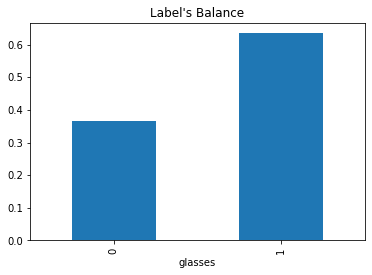

In [6]:
%matplotlib inline
(df.groupby('glasses').size()/df.shape[0]).plot(kind="bar",title="Label's Balance")

# Data Preprocessing

The dataset is unbalanced. In order to solve this issue, we are going to augment our dataset to reequilibrate it, by having as much pictures of people wearing glasses than not wearing glasses.

In [21]:
# Number of pictures to augment
nb_to_augment = len(df[df['glasses']==1]) - len(df[df['glasses']==0])

# Corresponding dataframe
df_to_augment = df[df['glasses']==0].iloc[:nb_to_augment,:]

In [22]:
df_aug = pd.DataFrame([np.arange(4501,5713),np.zeros(nb_to_augment,dtype=int)]).transpose()
df_aug.columns = ['id','glasses']
df = pd.concat([df,df_aug],ignore_index=True)
df['path'] = df.apply(lambda row: path+'data/pictures/face-'+str(row.id)+'.png',axis=1)
df

,id,glasses,path
0,1,0,/media/hdd2/paulineberberi/data_glasses/pictur...
1,2,1,/media/hdd2/paulineberberi/data_glasses/pictur...
2,3,1,/media/hdd2/paulineberberi/data_glasses/pictur...
3,4,0,/media/hdd2/paulineberberi/data_glasses/pictur...
4,5,0,/media/hdd2/paulineberberi/data_glasses/pictur...
...,...,...,...
5707,5708,0,/media/hdd2/paulineberberi/data_glasses/pictur...
5708,5709,0,/media/hdd2/paulineberberi/data_glasses/pictur...
5709,5710,0,/media/hdd2/paulineberberi/data_glasses/pictur...
5710,5711,0,/media/hdd2/paulineberberi/data_glasses/pictur...


Let's augmentate those images by flipping them vectically

In [10]:
# indice_id is the index of the initial image to augment 
# indice_new is the new index that we're gonna create (above 4500)

def augment_image(indice_new=4501):
  k = indice_new  
  for indice_id in df_to_augment.id:
    image_original = io.imread(path_images+'face-'+str(indice_id)+'.png')
    image_aug = iaa.Fliplr(p=1.0).augment_image(image_original)
    imageio.imwrite(path_images+'face-'+str(k)+'.png',image_aug)
    k+=1
    if k%10 == 0:
      print(str(k-indice_new)+'/1212')
  
# augment_image()

You must not run ```augment_image``` since the provided dataset has already been augmented

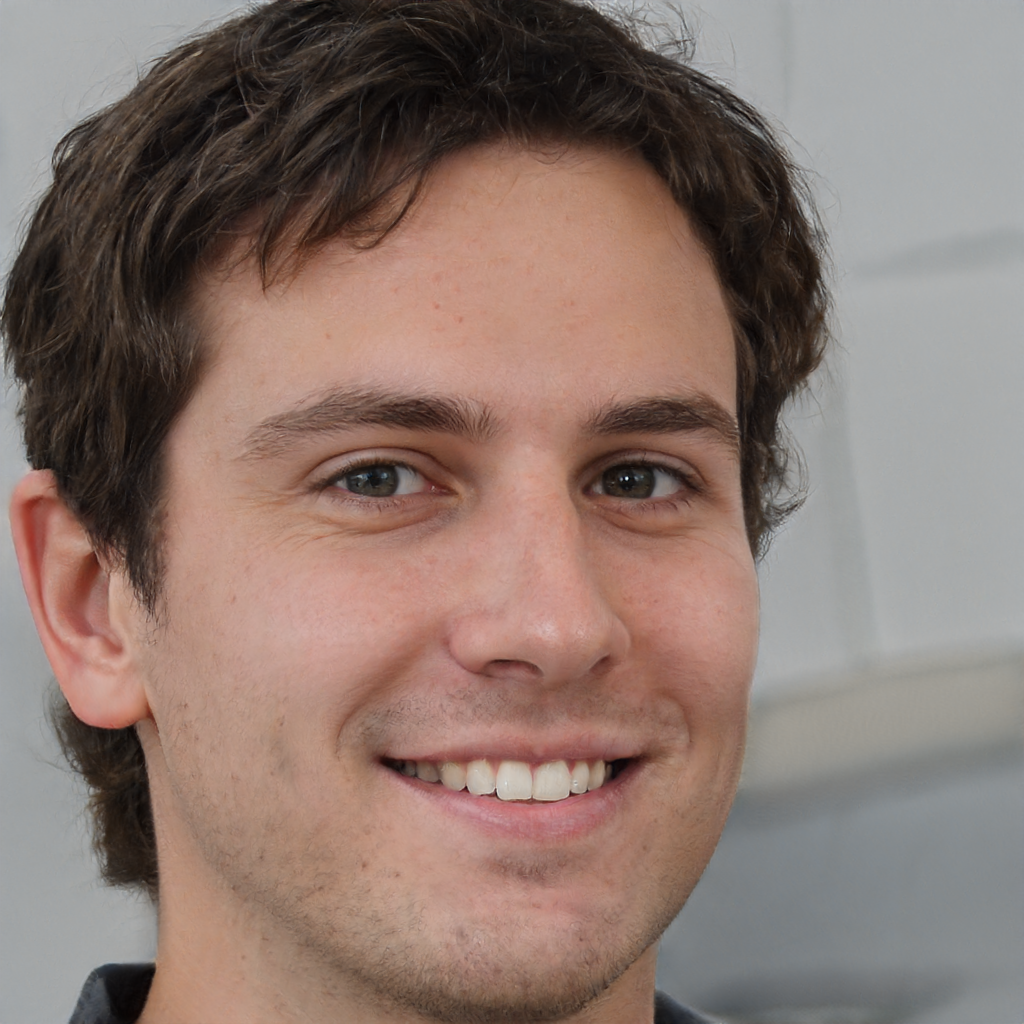

In [7]:
image = Image.open(r path+"data/pictures/face-1.png")
image

We notice that the image is quite big. 
First of all, since all our images are centered and that the eyes are always in the same place, we are going to crop the image in order to only use the part with the eyes. 
In addition to the computational gain, this prevents the network to get lost in non-relevant details.

In [8]:
left = 0
right = 1024
top = 300
bottom = 600

crop_left = left
crop_right = 1024 - right
crop_top = top
crop_bottom = 1024 - bottom

In [ ]:
im1 = image.crop((left, top, right, bottom))

This is what the images will look like. It's still quite big, so we are going to resize it to maake the computation more efficient.

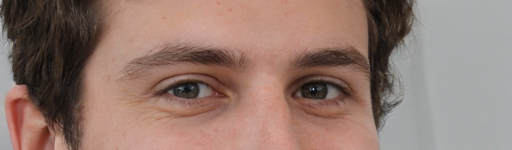

In [9]:
im1.resize( ( (right-left)//2,(bottom-top)//2 ) )

All those steps will be in the neural network

# Feature Engineering

We save all images in a numpy array. 
You must run the following cell the first time, and then comment it.

In [13]:
## UNCOMMENT THE FIRST TIME YOU RUN THE NOTEBOOK

# X_images = []
# np.empty(len(X_path))
# for i in range (len(df.path)):
#   X_images.append(io.imread(df.path.iloc[i]))
#   if i%100 == 0 :
#     print(str(i)+'/'+str(len(df.path)))

# np.save('/data/X_images.npy',X_images)

In [14]:
X_images = np.load(path+'data/X_images.npy')
Y = df.glasses

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X_images,pd.get_dummies(Y), test_size=0.15, stratify=Y)

# CNN

We are going to try two approaches in order to classify our dataset : with a homemade CNN and by transfer learning using VGG16

In [25]:
batch_size = 32
learning_rate=0.001
image_size = (1024,1024)
dropout=0.2
epochs=20

## Homemade

In [26]:
def homemade_cnn(resize_ratio=4,dropout=0.2):
  cnn = keras.models.Sequential()
  cnn.add(keras.Input(shape=image_size+(3,) )) 
  cnn.add(keras.layers.Cropping2D(cropping = ((crop_top,crop_bottom),(crop_left,crop_right)),name='cropping')) 
  cnn.add(keras.layers.experimental.preprocessing.Resizing(
    (bottom-top)//resize_ratio , (right-left)//resize_ratio,interpolation="bilinear", name='resizing'))
  cnn.add(keras.layers.experimental.preprocessing.Rescaling(scale=1./255, offset=0.0,name='rescaling'))
  cnn.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
  cnn.add(keras.layers.MaxPooling2D(2, 2))
  cnn.add(keras.layers.Dropout(dropout))  
  cnn.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
  cnn.add(keras.layers.MaxPooling2D(2,2))
  cnn.add(keras.layers.Dropout(dropout))
  cnn.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
  cnn.add(keras.layers.MaxPooling2D(3,3))
  cnn.add(keras.layers.Dropout(dropout))
  cnn.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
  cnn.add(keras.layers.MaxPooling2D(3,3))
  cnn.add(keras.layers.Flatten())
  cnn.add(keras.layers.Dense(128, activation='relu'))
  cnn.add(keras.layers.Dense(2, activation='softmax'))
  Adam=tf.keras.optimizers.Adam(learning_rate=learning_rate)
  cnn.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
  return cnn

We use MLFlow to monitor our performance according to the models and hyperparameters

In [27]:
with mlflow.start_run(run_name = 'homemade'):

    cnn1 = homemade_cnn()
    mlflow.tensorflow.autolog(every_n_iter=1)
    history = cnn1.fit(X_train,Y_train,epochs=epochs,validation_split=0.2, batch_size = batch_size)
    mlflow.keras.log_model(cnn1, "homemade cnn")
    mlflow.end_run()
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

Epoch 1/20
122/122 [==============================] - 61s 493ms/step - loss: 0.6625 - accuracy: 0.5757 - val_loss: 0.3263 - val_accuracy: 0.8867
Epoch 2/20
122/122 [==============================] - 58s 476ms/step - loss: 0.3412 - accuracy: 0.8792 - val_loss: 0.3045 - val_accuracy: 0.8919
Epoch 3/20
122/122 [==============================] - 58s 473ms/step - loss: 0.3051 - accuracy: 0.8949 - val_loss: 0.3186 - val_accuracy: 0.8908
Epoch 4/20
122/122 [==============================] - 58s 472ms/step - loss: 0.2988 - accuracy: 0.8918 - val_loss: 0.2943 - val_accuracy: 0.8970
Epoch 5/20
122/122 [==============================] - 57s 471ms/step - loss: 0.2980 - accuracy: 0.8902 - val_loss: 0.2806 - val_accuracy: 0.8929
Epoch 6/20
122/122 [==============================] - 58s 474ms/step - loss: 0.2848 - accuracy: 0.8935 - val_loss: 0.2641 - val_accuracy: 0.8991
Epoch 7/20
122/122 [==============================] - 58s 472ms/step - loss: 0.2618 - accuracy: 0.9013 - val_loss: 0.2932 - val_ac

In [31]:
cnn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping (Cropping2D)        (None, 300, 1024, 3)      0         
_________________________________________________________________
resizing (Resizing)          (None, 75, 256, 3)        0         
_________________________________________________________________
rescaling (Rescaling)        (None, 75, 256, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 73, 254, 64)       1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 127, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 127, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 125, 64)       3

Evaluation of our homemade model

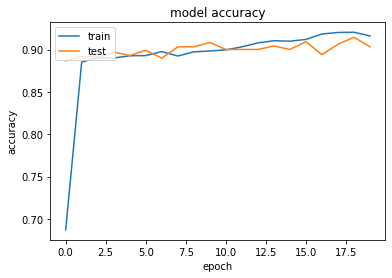

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

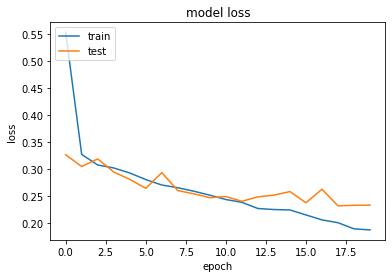

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
Y_pred_homemade = cnn1.predict(X_test).argmax(axis=1)

<AxesSubplot:>

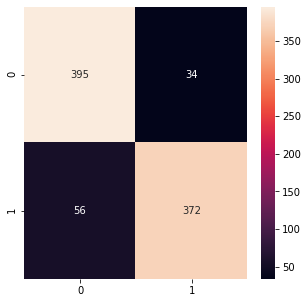

In [36]:
confusion_mat = sklearn.metrics.confusion_matrix(Y_test[1], Y_pred_homemade)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_mat, annot=True, fmt="d")

AUC value: 0.8949523996252968


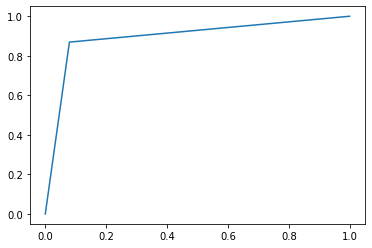

In [37]:
from sklearn.metrics import roc_curve, auc, plot_roc_curve, roc_auc_score
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test[1], Y_pred_homemade)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("AUC value:",roc_auc_score(Y_test[1], Y_pred))

## Transfert Learning

In [38]:
def transfer_cnn(loss = tf.keras.losses.CategoricalCrossentropy() , resize_ratio = 4):

    inputt = tf.keras.layers.Input( shape=image_size+(3,) )
    x = tf.keras.layers.Cropping2D(cropping = ((crop_top,crop_bottom),(crop_left,crop_right)),name='Cropping')(inputt)
    x = tf.keras.layers.experimental.preprocessing.Resizing(
    (bottom-top)//resize_ratio , (right-left)//resize_ratio,interpolation="bilinear", name='Resizing')(x)

    vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
    for layer in vgg16.layers:#[:15]
        layer.trainable = False

    x = vgg16(x)

    x = tf.keras.layers.Flatten(input_shape=vgg16.output_shape[1:])(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputt, outputs=x)
    model.compile(loss=loss,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),metrics=['accuracy'])
    return model

In [40]:
with mlflow.start_run(run_name = 'transfer'):

    cnn2 = transfer_cnn()
    mlflow.tensorflow.autolog(every_n_iter=1)
    history = cnn2.fit(X_train,Y_train,epochs=20,validation_split=0.2, batch_size = batch_size)
    mlflow.keras.log_model(cnn2, "transfer learning cnn")
    mlflow.end_run()
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

Epoch 1/20
122/122 [==============================] - 135s 1s/step - loss: 4.6142 - accuracy: 0.7755 - val_loss: 0.3224 - val_accuracy: 0.8898
Epoch 2/20
122/122 [==============================] - 141s 1s/step - loss: 0.3952 - accuracy: 0.8472 - val_loss: 0.3401 - val_accuracy: 0.8805
Epoch 3/20
122/122 [==============================] - 142s 1s/step - loss: 0.3427 - accuracy: 0.8720 - val_loss: 0.3165 - val_accuracy: 0.8836
Epoch 4/20
122/122 [==============================] - 142s 1s/step - loss: 0.3454 - accuracy: 0.8803 - val_loss: 0.3009 - val_accuracy: 0.8960
Epoch 5/20
122/122 [==============================] - 141s 1s/step - loss: 0.3459 - accuracy: 0.8724 - val_loss: 0.2888 - val_accuracy: 0.8929
Epoch 6/20
122/122 [==============================] - 142s 1s/step - loss: 0.3142 - accuracy: 0.8753 - val_loss: 0.3036 - val_accuracy: 0.8980
Epoch 7/20
122/122 [==============================] - 143s 1s/step - loss: 0.2903 - accuracy: 0.8734 - val_loss: 0.3357 - val_accuracy: 0.8898

In [43]:
cnn2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1024, 1024, 3)]   0         
_________________________________________________________________
Cropping (Cropping2D)        (None, 300, 1024, 3)      0         
_________________________________________________________________
Resizing (Resizing)          (None, 75, 256, 3)        0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0   

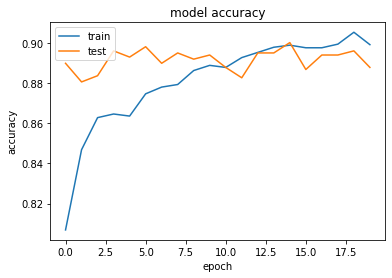

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

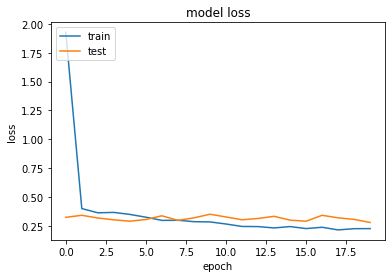

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluation of our transfer learning model

In [44]:
Y_pred_transfer = cnn2.predict(X_test).argmax(axis=1)

<AxesSubplot:>

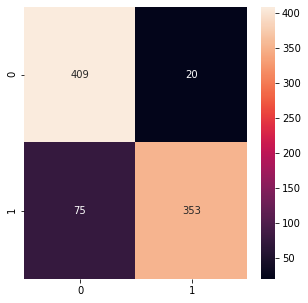

In [45]:
confusion_mat = sklearn.metrics.confusion_matrix(Y_test[1], Y_pred_transfer)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_mat, annot=True, fmt="d")

AUC value: 0.8890731542600703


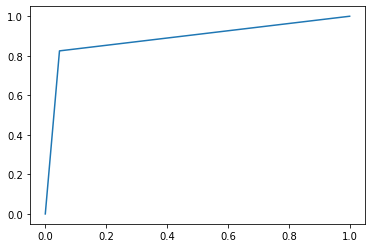

In [46]:
from sklearn.metrics import roc_curve, auc, plot_roc_curve, roc_auc_score
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test[1], Y_pred_transfer)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("AUC value:",roc_auc_score(Y_test[1], Y_pred_transfer))

## Two models comparaison

In [47]:
def phrase_prediction(int):
    if int == 0 : 
        print('Prediction : no glasses')
    else :
        print('Prediction : glasses')

In [48]:
print('Percentage of different prediction between the two models : '+str(
int(np.sum(np.abs(Y_pred_transfer - Y_pred_homemade)) / Y_pred_transfer.shape[0] * 100))+' %')

Percentage of different prediction between the two models : 6 %


Homemade :
Prediction : glasses


Transfer :
Prediction : glasses


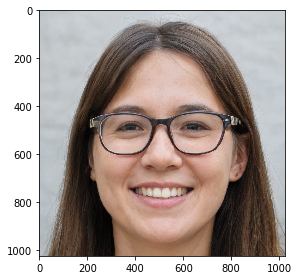

In [49]:
index = 1 # you can change it !

io.imshow(X_test[index,:,:,:])
print('Homemade :')
phrase_prediction(Y_pred_homemade[index])
print('\n')
print('Transfer :')
phrase_prediction(Y_pred_transfer[index])